In [48]:
#
# Calibrate StrepA ABM with LFIRE using simulation-step indices 

import os
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use("Agg")  # headless

import elfi
import pylfire
from numpy.random import default_rng, SeedSequence
from numpy.random import Generator as _NpGen, RandomState as _RS

from pylfire.classifiers.classifier import Classifier
from sklearn.linear_model import LogisticRegressionCV

import functions_list



In [49]:
# 0) Fixed hyperparameters (order MUST match functions_list.parameters())
# parameters(): [DurationSimulation, Nstrains, Dimmunity, sigma, omega, x,
#                Cperweek, Nagents, alpha, AgeDeath, BasicReproductionNumber]
# ----------------------------
DurationSimulation = 20.0       # years
Nstrains = 42
Dimmunity = 0.5 * 52.14         # weeks
omega = 0.1
x = 10.0
Cperweek = 34.53
Nagents = 2500
alpha = 3.0
AgeDeath = 71.0


# R0_LOW,  R0_HIGH  = 0.0, 5.0  # reproductionNumber 
# SIG_LOW, SIG_HIGH = 0.5, 1.0  # sigma 

In [50]:
# ----------------------------
# 1) Observations: treat these as SIMULATION STEP INDICES directly
#    (no conversions). Any index outside the simulated range is dropped.
# ----------------------------


df = pd.read_csv("./data/data_real.csv")
df_array = df.astype(float).to_numpy()
y_obs_array = df_array.T 
consultations = np.asarray([27,21,42,51,36,69,
                 122,149,172,170,142,147, 
                 40,193,183,211,190,182, 
                 199,130,191,188,161]).ravel()
# print(y_obs_array)
# print(y_obs_array_scaled)


In [51]:
# ----------------------------
# 2) Priors for (BasicReproductionNumber R0, sigma)
# ----------------------------
R0_LOW,  R0_HIGH  = 0.0, 5.0
SIG_LOW, SIG_HIGH = 0.5, 1.5

In [52]:
# ----------------------------
# 3) Build ABM param vector (theta = [R0, sigma])
# ----------------------------
def build_params(theta2):
    th = np.asarray(theta2, float).ravel()
    if th.size < 2:
        raise ValueError(f"theta2 must be length-2, got {np.shape(theta2)}")
    R0, sigma = float(th[0]), float(th[1])
    return np.array([
        DurationSimulation, Nstrains, Dimmunity, sigma, omega, x,
        Cperweek, Nagents, alpha, AgeDeath, R0
    ], dtype=float)

In [53]:
# ----------------------------
# 4) One ABM run → full prevalence series (length T)
# ----------------------------

def seed_from_theta(theta2, master_seed: int = 123) -> int:
    th = np.asarray(theta2, np.float64).ravel()
    b  = th.tobytes() + np.uint64(master_seed).tobytes()
    return int.from_bytes(hashlib.sha1(b).digest()[:8], 'little')
    
def simulate_prevalence_v5_numba(theta2, seed):
    # derive a child seed from ELFI's rng
    # rng = default_rng(seed)0
    seed = seed_from_theta(theta2, master_seed=seed)
    rng = default_rng(seed)
    params = build_params(theta2)
    AC, IMM, _ = functions_list.initialise_agents_v5(params, rng=rng)

    # call the reproducible simulator that uses only this seed
    SSPrev_selected, SSPrev, AIBKS = functions_list.simulator_v5_numba(
        AC, IMM, params, 0, 1, seed=seed
    )

    # Option A: return the 42x23 matrix (strain × selected times)
    return SSPrev_selected.astype(float)


In [54]:
# ----------------------------
# 5) Filter indices to those available from the simulator; align y_obs
# ----------------------------
# Dry run to learn T
import hashlib
_Tdry = simulate_prevalence_v5_numba(np.array([2.0, 1.0], float), seed=int(123))
T = _Tdry.size 
print("T's size", T)
_Tdry1 = simulate_prevalence_v5_numba(np.array([2.0, 1.0], float), seed=int(123))
print(np.allclose(_Tdry, _Tdry1), _Tdry.shape == _Tdry1.shape)

T's size 966
True True


In [55]:
print(_Tdry)

[[ 1.  1.  0.  0.  1.  0.  3.  2.  2.  3.  1.  7.  1.  5.  4.  3.  1.  4.
   7.  4.  5.  1.  7.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.]
 [ 0.  1.  1.  1.  0.  4.  2.  3.  4.  4.  5.  4.  1.  5.  6.  2.  1.  2.
   2.  0.  2.  5.  4.]
 [ 0.  0.  1.  2.  0.  1.  1.  2.  2.  0. 10.  1.  2.  1.  4.  4.  5.  8.
  11.  5.  6.  6.  8.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  4.  4.  0.
   5.  3.  6.  4.  6.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  2.  4.  8. 11.
  14.  8.  6.  5.  1.]
 [ 1.  1.  0.  1.  0.  0.  3.  5.  2.  2.  1.  3.  2.  6.  4. 12.  6.  5.
   3.  3.  4.  3.  2.]
 [ 0.  0.  0.  1.  0.  0.  2.  1.  2.  3.  2.  2.  2.  8. 12.  5. 12.  7.
   4.  4.  7.  8.  2.]
 [ 0.  1.  0.  1.  2.  3.  2.  2.  5.  2.  2.  1.  2.  0.  0.  0.  4.  3.
   4.  1.  3.  5.  9.]
 [ 0.  0.  1.  2.  0.  1.  8. 

In [56]:
# ----------------------------
# 6) Summary function on the selected values
# ----------------------------
def my_summary(series_1d):
    y = np.asarray(series_1d, float).ravel()
    n = y.size
    if n == 0:
        return np.array([np.nan, np.nan, np.nan, np.nan, 0.0], float)
    auc   = float(np.trapz(y))
    peak  = float(np.max(y))
    tpk   = float(np.argmax(y) / max(n, 1))   # relative peak time
    last  = float(y[-1])
    rough = float(np.sum(np.diff(y)**2)) if n > 1 else 0.0
    return np.array([auc, peak, tpk, last, rough], float)

In [57]:
# *** 1. AvgTimeObsStr
# Take SSPrev_obs>0 (presence/absence). Sum across time for each strain ⇒ “how many time points this strain was seen”. Then average over strains that were ever seen.
# → “On average, how long (in time points) an observed strain stayed detectable.”
def avg_time_obs_str(SSPrev_obs: np.ndarray, *, nan_if_none: bool = True) -> float:
    """
    AvgTimeObsStr: average # of time points a *seen* strain is present (>0).

    SSPrev_obs : (n_strains, T) array of counts per strain per time step.
    nan_if_none: if True, return np.nan when no strain is ever seen; else 0.0.
    """
    X = np.asarray(SSPrev_obs, dtype=float)
    # presence/absence per strain over time
    present = (X > 0).astype(np.int32)        # (S, T)
    per_strain_counts = present.sum(axis=1)   # (S,)
    seen = per_strain_counts[per_strain_counts > 0]
    if seen.size == 0:
        return float("nan") if nan_if_none else 0.0
    return float(seen.mean())

# *** 2.  MaxTimeObsStr
# From the same per-strain counts: take the maximum.
# → “Longest observed persistence (in time points) among all strains.”

def max_time_obs_str(SSPrev_obs: np.ndarray, *, nan_if_none: bool = True) -> float:
    """
    MaxTimeObsStr: longest observed persistence (in time points) among all strains.

    SSPrev_obs : (n_strains, T) array of counts per strain per time step.
    nan_if_none: if True, return np.nan when no strain is ever seen; else 0.0.
    """
    X = np.asarray(SSPrev_obs, dtype=float)
    present = (X > 0).astype(np.int32)        # (S, T) presence/absence
    per_strain_counts = present.sum(axis=1)   # time-points seen for each strain
    seen = per_strain_counts[per_strain_counts > 0]
    if seen.size == 0:
        return float("nan") if nan_if_none else 0.0
    return float(seen.max())


# *** 3. NumStrainsObs
# Count how many strains were ever observed (any nonzero across time).
# → “Total observed strain richness.”

def num_strains_obs_str(SSPrev_obs: np.ndarray) -> int:
    """
    Count how many strains were ever observed (any nonzero across time).

    SSPrev_obs : (n_strains, T) array of counts per strain per time step.

    Returns
    -------
    int
        Number of strains with at least one nonzero entry.
    """
    X = np.asarray(SSPrev_obs)
    return int(np.any(X > 0, axis=1).sum())

# *** 4. AvgTimeRepeatInf
# Apply timerepeat(SSPrev_obs): for each strain’s presence/absence row, take indices where present and compute gaps between successive presences; pool all strains’ gaps together and take the mean.
# → “Average time between repeat detections (recurrences) across strains.”

def avg_time_repeat_inf_numpy(SSPrev_obs: np.ndarray, *, nan_if_empty: bool = True) -> float:
    """
    Average time between repeat detections across strains.
    For each strain (row), take presence indices, compute gaps (np.diff),
    pool all gaps across strains, then return the mean gap.
    """
    X = (np.asarray(SSPrev_obs, float) > 0)  # (S, T) boolean presence
    gaps_all = []
    for row in X:
        idx = np.flatnonzero(row)           # times where present
        if idx.size >= 2:
            gaps_all.append(np.diff(idx))   # gaps between presences for this strain
    if not gaps_all:
        return float("nan") if nan_if_empty else 0.0
    gaps = np.concatenate(gaps_all).astype(float)
    return float(gaps.mean())

# *** 5. VarTimeRepeatInf
# Variance of those pooled inter-occurrence gaps.
# → “How variable the recurrence intervals are.”

def var_time_repeat_inf_numpy(SSPrev_obs, *, nan_if_empty: bool = True) -> float:
    """
    Variance (sample, ddof=1) of pooled gaps between repeat detections across strains.
    """
    X = (np.asarray(SSPrev_obs, float) > 0)  # (S, T) boolean presence
    gaps_all = []
    for row in X:
        idx = np.flatnonzero(row)
        if idx.size >= 2:
            gaps_all.append(np.diff(idx))
    if not gaps_all:
        return float("nan") if nan_if_empty else 0.0
    gaps = np.concatenate(gaps_all).astype(float)
    return float(np.var(gaps, ddof=1)) if gaps.size > 1 else (float("nan") if nan_if_empty else 0.0)


# *** 6. AvgPrev
# Mean of Prevalence_obs over time.
# → “Average prevalence in the observation window.”

def avg_prev_numpy(Prevalence_obs) -> float:
    """
    Average prevalence over time.
    Accepts array-like (T,) or (T,1). NaNs ignored.
    """
    y = np.asarray(Prevalence_obs, dtype=float).ravel()
    return float(np.nanmean(y)) if y.size else float("nan")


# *** 7. VarPrev
# Variance of Prevalence_obs over time.
# → “How much prevalence fluctuates.”

def var_prev_numpy(Prevalence_obs, ddof: int = 1) -> float:
    """
    Variance of prevalence over time (ignores NaNs).
    Prevalence_obs: array-like (T,) or (T,1)
    ddof: 1 for sample variance (MATLAB-like), 0 for population variance.
    """
    y = np.asarray(Prevalence_obs, dtype=float).ravel()
    if y.size == 0:
        return float("nan")
    # need at least 2 valid points for sample variance
    if ddof == 1 and np.sum(~np.isnan(y)) < 2:
        return float("nan")
    return float(np.nanvar(y, ddof=ddof))

# *** 8. AvgDiv
# Mean of Diversity_obs over time (your diversity metric per time step, e.g., reciprocal Simpson).
# → “Average strain diversity over time.”

def avg_div_numpy(Diversity_obs) -> float:
    """
    Average strain diversity over time (ignores NaNs).
    Diversity_obs: array-like of shape (T,) or (T,1)
    """
    y = np.asarray(Diversity_obs, dtype=float).ravel()
    return float(np.nanmean(y)) if y.size else float("nan")
    

# *** 9. VarDiv
# Variance of Diversity_obs.
# → “How much strain diversity fluctuates.”

def var_div_numpy(Diversity_obs, ddof: int = 1) -> float:
    """
    Variance of diversity over time (ignores NaNs).
    Diversity_obs: array-like (T,) or (T,1)
    ddof: 1 for sample variance (MATLAB-like), 0 for population variance.
    """
    y = np.asarray(Diversity_obs, dtype=float).ravel()
    if y.size == 0:
        return float("nan")
    if ddof == 1 and np.sum(~np.isnan(y)) < 2:
        return float("nan")
    return float(np.nanvar(y, ddof=ddof))

# *** 10. MaxAbundance
# max(max(SSPrev_obs)): the single highest count seen for any strain at any time.
# → “Peak abundance of a strain at a time point.”

def max_abundance_numpy(SSPrev_obs) -> float:
    """
    Peak abundance of a strain at any time.
    SSPrev_obs: array-like (n_strains, T). NaNs ignored.
    """
    X = np.asarray(SSPrev_obs, dtype=float)
    if X.size == 0 or np.isnan(X).all():
        return float("nan")
    return float(np.nanmax(X))

# *** 11. AvgNPMI (MI(SSPrev_obs))
# Average normalized pointwise mutual information across strain pairs using presence/absence over time. Positive ⇒ co-occur more than chance; ~0 ⇒ independent; negative ⇒ avoid each other.
# → “Average pairwise co-occurrence beyond chance.”

def avg_npmi_numpy(SSPrev_obs) -> float:
    """
    Average normalized PMI across strain pairs using presence/absence over time.
    Skips pairs with p_ij == 0. Returns NaN if no valid pairs.
    """
    X = (np.asarray(SSPrev_obs, dtype=float) > 0).astype(np.int32)  # (S, T)
    S, T = X.shape
    if S < 2 or T == 0:
        return float("nan")

    # per-strain presence probability
    c_i = X.sum(axis=1).astype(float)          # (S,)
    p_i = c_i / T

    # pairwise co-occurrence counts & probabilities
    C = X @ X.T                                # (S, S) co-occurrence counts
    iu = np.triu_indices(S, k=1)
    c_ij = C[iu].astype(float)
    p_ij = c_ij / T

    # valid pairs: p_ij>0 and p_i,p_j>0
    pi_i = p_i[iu[0]]
    pi_j = p_i[iu[1]]
    valid = (p_ij > 0) & (pi_i > 0) & (pi_j > 0)
    if not np.any(valid):
        return float("nan")

    pij = p_ij[valid]
    pmi = np.log(pij / (pi_i[valid] * pi_j[valid]))
    npmi = pmi / (-np.log(pij))
    return float(np.mean(npmi))


# *** 12. DivAllIsolates
# First collapse time by summing counts per strain: sum(SSPrev_obs, 2) (i.e., total isolates per strain across all time). Then compute your diversity function div(...) on that vector.
# → “Overall strain diversity across the entire study period (richness + evenness), time-collapsed.”

def div_all_isolates_numpy(SSPrev_obs) -> float:
    """
    Overall strain diversity across the entire study period.
    Steps:
      1) Collapse time: totals per strain = sum over columns (time).
      2) Reciprocal Simpson: D = N*(N-1) / sum_i n_i*(n_i-1)
         (returns 0 if no isolates; equals richness when all n_i ∈ {0,1})
    """
    X = np.asarray(SSPrev_obs, dtype=float)
    if X.size == 0:
        return 0.0
    totals = X.sum(axis=1)              # per-strain totals across time
    N = totals.sum()
    if N <= 1:
        return 0.0
    denom = np.sum(totals * (totals - 1.0))
    if denom <= 0:
        # all totals are 0 or 1 → diversity equals number of nonzero strains
        return float((totals > 0).sum())
    return float(N * (N - 1.0) / denom)


def my_summary_v5_numba(series_2d):
    y = np.asarray(series_2d, float).ravel()
    avg_time_obs = avg_time_obs_str(series_2d)
    max_time_obs = max_time_obs_str(series_2d)
    num_strains_obs = num_strains_obs_str(series_2d)
    avg_time_repeat_obs = avg_time_repeat_inf_numpy(series_2d)
    var_time_repeat_obs = var_time_repeat_inf_numpy(series_2d)
    
    return np.array([avg_time_obs, max_time_obs, num_strains_obs, avg_time_repeat_obs, var_time_repeat_obs], float)


In [111]:
s_obs_v5_numba = my_summary_v5_numba(_Tdry)
y_obs_array = _Tdry
print("s_obs", s_obs_v5_numba)

s_obs [16.80769231 22.         26.          1.15571776  0.26349772]


In [60]:
# ----------------------------
# 7) Robust ELFI random_state → int seed
# ----------------------------
def _seed_from_random_state(random_state):
    if isinstance(random_state, _NpGen):
        return int(random_state.integers(0, 2**32 - 1))
    if isinstance(random_state, _RS):
        return int(random_state.randint(0, 2**32 - 1))
    if isinstance(random_state, (int, np.integer)):
        return int(random_state)
    return int(np.random.randint(0, 2**32 - 1))

In [92]:
# ----------------------------
# 8) ELFI simulator: return simulated values at YOUR indices (idx_valid)
# ----------------------------

def elfi_simulator_v5_numba(R0, sigma, batch_size=1, random_state=None):
    R0    = np.atleast_1d(np.asarray(R0, float))
    sigma = np.atleast_1d(np.asarray(sigma, float))
    bs = int(max(R0.size, sigma.size, int(batch_size)))
    if R0.size == 1:    R0    = np.repeat(R0, bs)
    if sigma.size == 1: sigma = np.repeat(sigma, bs)

    seed = _seed_from_random_state(random_state)
    ss_parent = SeedSequence(seed)
    children = ss_parent.spawn(bs)

    outs = []
    for i in range(bs):
        theta_i = np.array([R0[i], sigma[i]], float)
        # Convert child SeedSequence -> stable 32-bit integer seed
        seed_i = int(children[i].generate_state(1, dtype=np.uint32)[0])
        prev_i = simulate_prevalence_v5_numba(theta_i, seed=seed_i)  # (42, 23)
        outs.append(prev_i)                  # pick your indices only
    return np.stack(outs, axis=0)                       # (bs, len(idx_valid))

In [93]:
# ----------------------------
# 9) Build ELFI graph (no context manager)
# ----------------------------
m = elfi.new_model()
R0_node  = elfi.Prior('uniform', R0_LOW,  R0_HIGH  - R0_LOW,  model=m, name='R0')
SIG_node = elfi.Prior('uniform', SIG_LOW, SIG_HIGH - SIG_LOW, model=m, name='sigma')
sim_node = elfi.Simulator(elfi_simulator_v5_numba, R0_node, SIG_node, model=m, name='sim')
summary_node = elfi.Summary(my_summary_v5_numba, sim_node, observed=s_obs_v5_numba, model=m, name='summary')


In [94]:
# ----------------------------
# 10) Build LFIRE classifier
# ----------------------------
class SKLogitClassifierAdapter(Classifier):
    parallel_cv = False  # tell PYLFIRE not to parallelize via ELFI client

    def __init__(self, cv=5, n_jobs=1, max_iter=2000):
        # do NOT call super().__init__()
        self.cv = int(cv)
        self.n_jobs = None if int(n_jobs) == 1 else int(n_jobs)
        self.max_iter = int(max_iter)
        self.models_ = {}

    def fit(self, X, y, index=0):
        X = np.asarray(X, float)
        y = np.asarray(y)

        # Ensure 2D features
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        # Map {-1,+1} -> {0,1} if needed
        uniq = np.unique(y)
        if set(uniq.tolist()) == {-1, 1}:
            y = ((y + 1) // 2).astype(int)

        # Effective CV ≤ samples per class (min 2)
        n_pos = int((y == 1).sum())
        n_neg = int((y == 0).sum())
        cv_eff = max(2, min(self.cv, n_pos, n_neg))

        lr = LogisticRegressionCV(
            cv=cv_eff, max_iter=self.max_iter, solver="lbfgs",
            scoring="neg_log_loss", n_jobs=self.n_jobs
        )
        lr.fit(X, y)
        self.models_[index] = lr
        return self

    def predict_likelihood_ratio(self, obs, index=0):
        lr = self.models_[index]
        obs = np.asarray(obs, float).ravel()

        # Match feature count used in fit
        n_feat = int(getattr(lr, "n_features_in_", obs.size))
        if obs.size != n_feat:
            if obs.size > n_feat:
                obs = obs[:n_feat]
            else:
                obs = np.pad(obs, (0, n_feat - obs.size), mode="constant", constant_values=0.0)

        obs = obs.reshape(1, -1)
        proba = lr.predict_proba(obs)[0]
        classes = lr.classes_
        pos_idx = int(np.where(classes == 1)[0][0]) if 1 in classes else 1
        p1 = float(proba[pos_idx])
        p0 = max(1e-12, 1.0 - p1)
        return p1 / p0


In [95]:
# ----------------------------
# 11) Parameter grid for LFIRE
# ----------------------------
FAST = 1
# ---- fast settings ----
if FAST:
    Nstrains = 42                # (was 42)
    Nagents = 2500               # (was 2500)
    # tiny LFIRE grid
    R0_grid  = np.linspace(R0_LOW,  R0_HIGH,  5)
    SIG_grid = np.linspace(SIG_LOW, SIG_HIGH, 4)
    batch_size_lfire = 32       # (was 512)
else:
    # original grid / batch size
    R0_grid  = np.linspace(R0_LOW,  R0_HIGH,  40)
    SIG_grid = np.linspace(SIG_LOW, SIG_HIGH, 20)
    batch_size_lfire = 64

TT1, TT2 = np.meshgrid(R0_grid, SIG_grid, indexing='ij')
params_grid = np.c_[TT1.ravel(), TT2.ravel()]  # (40*20, 2)

In [96]:
# ----------------------------
# 12) Run LFIRE
# ----------------------------
clf = SKLogitClassifierAdapter(cv=5, max_iter=2000)

# lfire = pylfire.LFIRE(
#     model=m,
#     params_grid=params_grid,
#     batch_size=batch_size_lfire,
#     classifier=clf,
#     output_names=['summary', 'R0', 'sigma']  # <-- add params here
# )

lfire = pylfire.LFIRE(
    model=m,
    params_grid=params_grid,
    batch_size=batch_size_lfire,
    classifier=clf,
    output_names=['summary', 'R0', 'sigma']  # <-- add params here
)
print("xxx")
res = lfire.infer()

xxx
Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [97]:
# ----------------------------
# 13) Save posterior results 
# ----------------------------
def extract_posterior_any(res, lfire_obj, params_grid):
    """Robustly pull (theta_grid, weights) from PYLFIRE/ELFI results."""
    theta, w = None, None

    # 1) Try dict-like/attr-like result first
    if isinstance(res, dict):
        theta = res.get("theta") or res.get("thetas") or res.get("grid")
        w = res.get("posterior") or res.get("weights") or res.get("post")
    else:
        theta = getattr(res, "theta", None)
        w = (getattr(res, "posterior", None)
             or getattr(res, "weights", None)
             or getattr(res, "post", None)
             or (getattr(res, "results", {}).get("weights") if hasattr(res, "results") else None))

    # 2) Pull from lfire.state (most reliable path)
    if (theta is None or w is None) and hasattr(lfire_obj, "state"):
        st = lfire_obj.state
        # get parameter names and stack their tracked values into a grid
        names = getattr(lfire_obj, "parameter_names", None)
        if not names:
            names = [k for k in ("R0", "sigma") if k in st]  # sensible default
        cols = []
        for nm in names:
            if nm in st:
                cols.append(np.asarray(st[nm]).ravel())
        if cols and all(c.size == cols[0].size for c in cols):
            theta = np.column_stack(cols)
        # posterior array is usually here
        w = st.get("posterior", w)

    # 3) As a last resort, evaluate posterior now (may be unnecessary)
    if (w is None) and hasattr(lfire_obj, "_evaluate_posterior"):
        try:
            ev = lfire_obj._evaluate_posterior()
            if isinstance(ev, dict):
                w = ev.get("posterior") or ev.get("weights") or ev.get("post")
            if theta is None:
                theta = params_grid
        except Exception:
            pass

    # 4) Final fallbacks
    if theta is None:
        theta = params_grid
    theta = np.asarray(theta, float)

    if w is None:
        # uniform fallback if classifier produced degenerate/hidden weights
        w = np.ones(theta.shape[0], float)
    else:
        w = np.asarray(w, float).ravel()

    # clean + normalise
    w = np.clip(w, 0, None)
    s = np.nansum(w)
    w = (np.ones_like(w) / max(w.size, 1)) if (not np.isfinite(s) or s <= 0) else (w / s)
    return theta, w

# use it
theta_grid, weights = extract_posterior_any(res, lfire_obj=lfire, params_grid=params_grid)

map_idx    = int(np.argmax(weights))
theta_map  = theta_grid[map_idx]
theta_mean = (weights[:, None] * theta_grid).sum(axis=0)

print(f"[RESULT] MAP: {theta_map} | Posterior mean: {theta_mean}")

import os, pandas as pd
os.makedirs("experimental_data", exist_ok=True)
pd.DataFrame(theta_grid, columns=["R0", "sigma"]).assign(weight=weights)\
  .to_csv("experimental_data/posterior_grid_v5.csv", index=False)
print("Saved → experimental_data/posterior_grid_v5.csv")

[RESULT] MAP: [2.5 1.5] | Posterior mean: [2.67085937 0.99979056]
Saved → experimental_data/posterior_grid_v4.csv


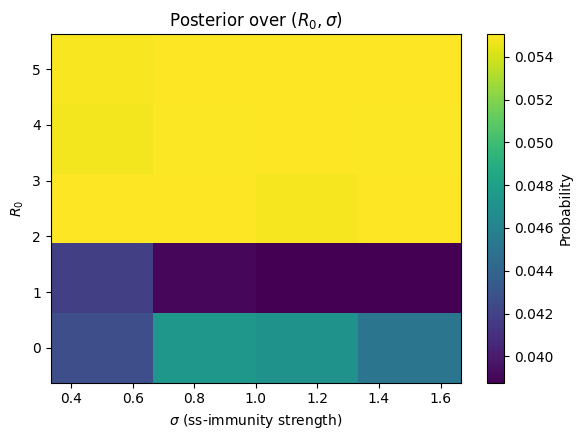

Saved → experimental_data/posterior_heatmap_v4.png


In [98]:
# ----------------------------
#  Heatmap 
# ----------------------------

# Get θ-grid and normalized weights
theta_grid = np.column_stack([np.asarray(lfire.state['R0']).ravel(),
                              np.asarray(lfire.state['sigma']).ravel()])
w = np.asarray(lfire.state.get('posterior'), float).ravel()
w = np.clip(w, 0, None); w = w / (w.sum() if w.sum() > 0 else 1.0)

%matplotlib inline

# or, in pure Python:
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')

import matplotlib.pyplot as plt
R0_vals  = np.unique(theta_grid[:,0])
SIG_vals = np.unique(theta_grid[:,1])

# reshape to 2D if grid is rectangular
if R0_vals.size * SIG_vals.size == theta_grid.shape[0]:
    post2d = w.reshape(R0_vals.size, SIG_vals.size, order='C')  # 'ij' meshgrid
    plt.figure(figsize=(6,4.5))
    plt.pcolormesh(SIG_vals, R0_vals, post2d, shading='auto')
    plt.xlabel(r'$\sigma$ (ss-immunity strength)')
    plt.ylabel(r'$R_0$')
    plt.title('Posterior over $(R_0, \sigma)$')
    plt.colorbar(label='Probability')
    plt.tight_layout()
    plt.savefig('experimental_data/posterior_heatmap_v5_numba.png', dpi=160)
    plt.show()
    plt.close()
    print("Saved → experimental_data/posterior_heatmap_v5_numba.png")

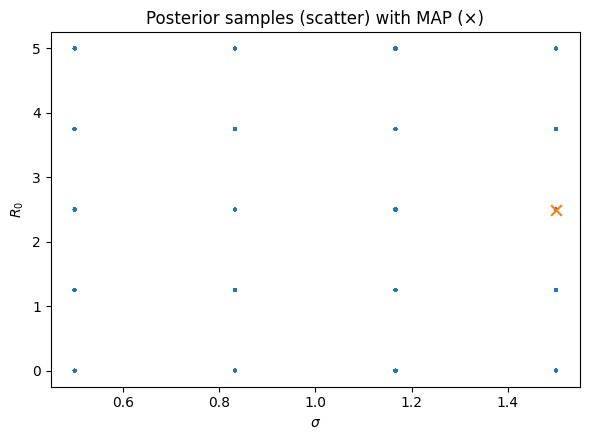

Saved → experimental_data/posterior_scatter_v4.png


In [99]:
# ----------------------------
#  draw samples from the discrete posterior
# ----------------------------
# 
rng = np.random.default_rng(0)
idx = rng.choice(theta_grid.shape[0], size=5000, replace=True, p=w)
samps = theta_grid[idx]
R0_s, SIG_s = samps[:,0], samps[:,1]

# MAP point
map_idx = int(np.argmax(w))
theta_map = theta_grid[map_idx]

plt.figure(figsize=(6,4.5))
plt.scatter(SIG_s, R0_s, s=6, alpha=0.25, edgecolors='none')
plt.scatter([theta_map[1]],[theta_map[0]], s=60, marker='x')
plt.xlabel(r'$\sigma$'); plt.ylabel(r'$R_0$'); plt.title('Posterior samples (scatter) with MAP (×)')
plt.tight_layout()
plt.savefig('experimental_data/posterior_scatter_v5_numba.png', dpi=160)
plt.show()
plt.close()
print("Saved → experimental_data/posterior_scatter_v5_numba.png")

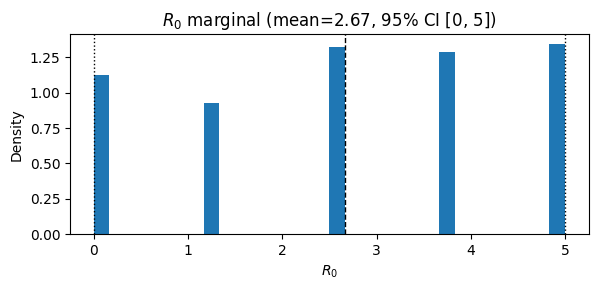

Saved → experimental_data/posterior_marginal_R0_v4.png


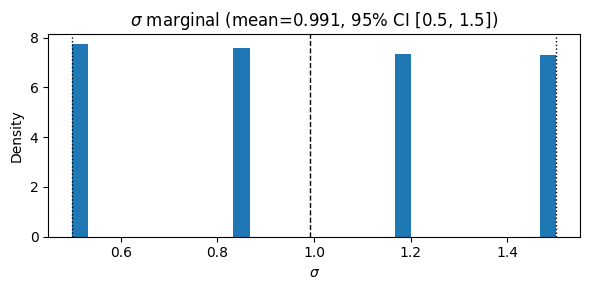

Saved → experimental_data/posterior_marginal_sigma_v4.png


In [100]:
# ----------------------------
#  Marginal densities + 95% CIs
# ----------------------------
# 
def ci95(a): 
    lo, hi = np.quantile(a, [0.025, 0.975]); return float(lo), float(hi)

lo_R0, hi_R0   = ci95(R0_s)
lo_SIG, hi_SIG = ci95(SIG_s)
mean_R0  = float(R0_s.mean())
mean_SIG = float(SIG_s.mean())

# R0
plt.figure(figsize=(6,3))
plt.hist(R0_s, bins=30, density=True)
plt.axvline(mean_R0, color='k', linestyle='--', linewidth=1)
plt.axvline(lo_R0,  color='k', linestyle=':',  linewidth=1)
plt.axvline(hi_R0,  color='k', linestyle=':',  linewidth=1)
plt.title(rf'$R_0$ marginal (mean={mean_R0:.3g}, 95% CI [{lo_R0:.3g}, {hi_R0:.3g}])')
plt.xlabel(r'$R_0$'); plt.ylabel('Density'); plt.tight_layout()
plt.savefig('experimental_data/posterior_marginal_R0_v5_numba.png', dpi=160)
plt.show()
plt.close()
print("Saved → experimental_data/posterior_marginal_R0_v5_numba.png")

# sigma
plt.figure(figsize=(6,3))
plt.hist(SIG_s, bins=30, density=True)
plt.axvline(mean_SIG, color='k', linestyle='--', linewidth=1)
plt.axvline(lo_SIG,  color='k', linestyle=':',  linewidth=1)
plt.axvline(hi_SIG,  color='k', linestyle=':',  linewidth=1)
plt.title(rf'$\sigma$ marginal (mean={mean_SIG:.3g}, 95% CI [{lo_SIG:.3g}, {hi_SIG:.3g}])')
plt.xlabel(r'$\sigma$'); plt.ylabel('Density'); plt.tight_layout()
plt.savefig('experimental_data/posterior_marginal_sigma_v5_numba.png', dpi=160)
plt.show()
plt.close()
print("Saved → experimental_data/posterior_marginal_sigma_v5_numba.png")

In [101]:
# ----------------------------
#  Get posterior over parameters (θ = [R0, σ])
# ----------------------------
# 
import numpy as np

# θ-grid from LFIRE’s state
theta_grid = np.column_stack([
    np.asarray(lfire.state['R0']).ravel(),
    np.asarray(lfire.state['sigma']).ravel()
])

# posterior weights (normalize)
w = np.asarray(lfire.state.get('posterior'), float).ravel()
w = np.clip(w, 0, None)
w = w / (w.sum() if w.sum() > 0 else 1.0)

# point estimates
i_map     = int(np.argmax(w))
theta_map = theta_grid[i_map]
theta_mean= (w[:, None] * theta_grid).sum(axis=0)

print(f"MAP:   R0={theta_map[0]:.3f}, sigma={theta_map[1]:.3f}")
print(f"Mean:  R0={theta_mean[0]:.3f}, sigma={theta_mean[1]:.3f}")

MAP:   R0=2.500, sigma=1.500
Mean:  R0=2.671, sigma=1.000


In [104]:
# Generate fitted curves (MAP & posterior predictive) 
from numpy.random import default_rng

rng = default_rng(0)

# helper: simulate & select your time indices
def sim_at(theta_2, seed=None):
    g = seed if seed is not None else rng
    full = simulate_prevalence_v5_numba(np.asarray(theta_2, float), g)
    return full   # <- your selected indices only

# MAP fit
y_hat_map = sim_at(theta_map, seed=123)

# Posterior predictive: sample θ from grid according to w, simulate many times
n_ppc = 500   # increase later for smoother bands
idxs = rng.choice(theta_grid.shape[0], size=n_ppc, replace=True, p=w)
ppc  = np.stack([sim_at(theta_grid[i], seed=int(rng.integers(0, 2**32-1)))
                 for i in idxs], axis=0)    # shape (n_ppc, L)
y_hat_mean = ppc.mean(axis=0)
lo, hi     = np.quantile(ppc, [0.025, 0.975], axis=0)  # 95% band

In [112]:
# Error metrics (raw points & summary)
def rmse_matrix(S, O, mask=None):
    S = np.asarray(S, float); O = np.asarray(O, float)
    if mask is not None:
        M = np.asarray(mask, bool)
        diff2 = (S - O)**2
        diff2 = diff2[M]
        return np.sqrt(diff2.mean())
    return np.sqrt(np.mean((S - O)**2))

def mape_matrix(S, O, eps=1e-12, mask=None):
    S = np.asarray(S, float); O = np.asarray(O, float)
    denom = np.where(np.abs(O) < eps, np.nan, O)  # ignore near-zero obs
    err = np.abs((S - O) / denom) * 100.0
    if mask is not None:
        err = err[np.asarray(mask, bool)]
    return np.nanmean(err)

def smape_matrix(S, O, eps=1e-12, mask=None):
    S = np.asarray(S, float); O = np.asarray(O, float)
    denom = np.maximum(eps, (np.abs(S) + np.abs(O)) / 2)
    err = 100.0 * np.abs(S - O) / denom
    if mask is not None:
        err = err[np.asarray(mask, bool)]
    return np.mean(err)

def frobenius_norm(S, O):
    # Equivalent to sqrt of sum of squares; if you want RMSE, divide by sqrt(S.size)
    return np.linalg.norm(S - O, ord='fro')

def rmse_per_time(S, O):
    # returns a vector of RMSE(t) then a scalar average
    diff = (S - O)**2
    rmse_t = np.sqrt(diff.mean(axis=0))
    return rmse_t, float(rmse_t.mean())

def rmse_per_strain(S, O):
    diff = (S - O)**2
    rmse_s = np.sqrt(diff.mean(axis=1))
    return rmse_s, float(rmse_s.mean())
def rmsd(a, b):
    a = np.asarray(a,float); b = np.asarray(b,float)
    return np.sqrt(np.mean((a-b)**2))

def mape(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true,float)
    y_pred = np.asarray(y_pred,float)
    denom = np.where(np.abs(y_true) < eps, np.nan, y_true)
    return np.nanmean(np.abs((y_pred - y_true)/denom)) * 100.0

# pointwise fit metrics
rmsd_map  = rmsd(y_obs_array, y_hat_map)
mape_map  = mape(y_obs_array, y_hat_map)
rmsd_mean = rmsd(y_obs_array, y_hat_mean)
mape_mean = mape(y_obs_array, y_hat_mean)

# summary-space metrics (optional)
s_obs     = my_summary(y_obs_array)
s_map     = my_summary(y_hat_map)
s_mean    = my_summary(y_hat_mean)
rmsd_sum_map  = rmsd(s_obs, s_map)
rmsd_sum_mean = rmsd(s_obs, s_mean)

print(f"MAP fit:   RMSD={rmsd_map:.4g},  MAPE={mape_map:.3g}%  | summary RMSD={rmsd_sum_map:.4g}")
print(f"Mean fit:  RMSD={rmsd_mean:.4g}, MAPE={mape_mean:.3g}% | summary RMSD={rmsd_sum_mean:.4g}")

MAP fit:   RMSD=4.064,  MAPE=111%  | summary RMSD=1136
Mean fit:  RMSD=3.135, MAPE=79.4% | summary RMSD=1611


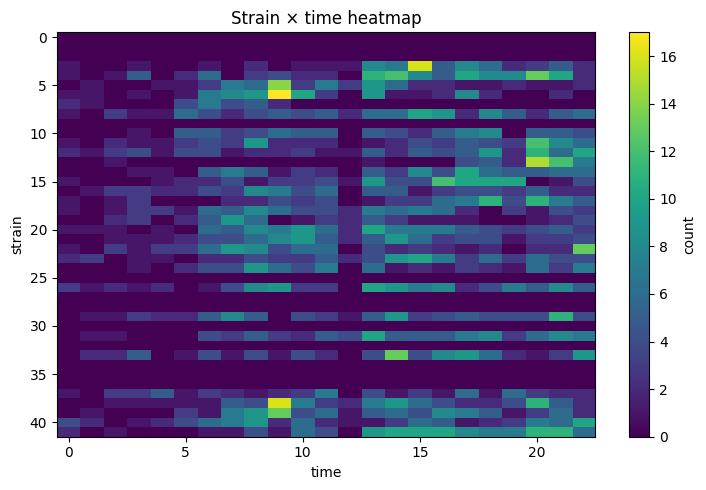

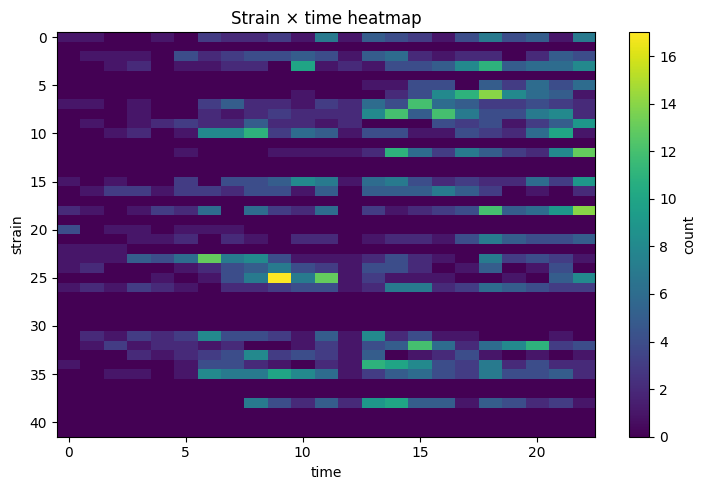

In [113]:
def plot_heatmap(M, fname="heatmap_v5_numba.png", vmax=None):
    M = np.asarray(M, float)
    plt.figure(figsize=(7.5,5))
    im = plt.imshow(M, aspect='auto', origin='upper',
                    interpolation='nearest', cmap='viridis',
                    vmin=np.nanmin(M), vmax=vmax)
    plt.colorbar(im, label="count")
    plt.xlabel("time"); plt.ylabel("strain")
    plt.title("Strain × time heatmap")
    plt.tight_layout()
    plt.savefig(fname, dpi=160)
    plt.show()
    plt.close()

plot_heatmap(y_hat_map, fname="experimental_data/SSPrev_heatmap_v5_numba.png")
plot_heatmap(y_obs_array, fname="experimental_data/SSPrev_heatmap_obs_v5_numba.png")

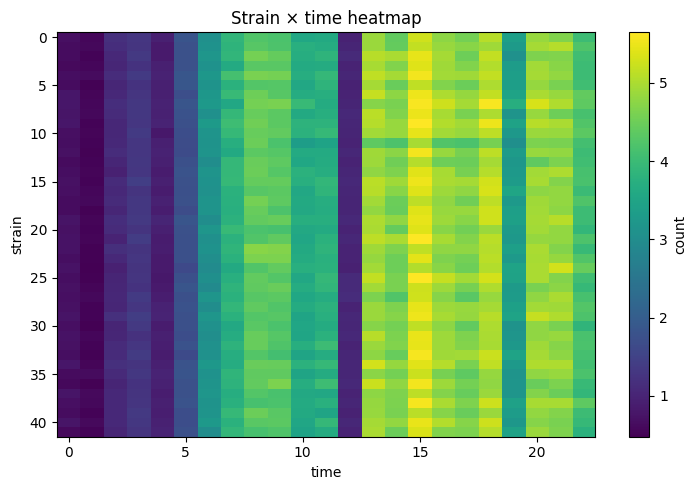

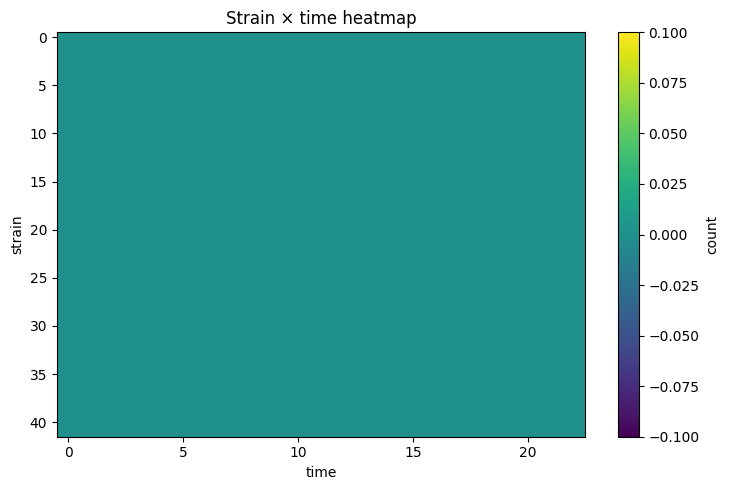

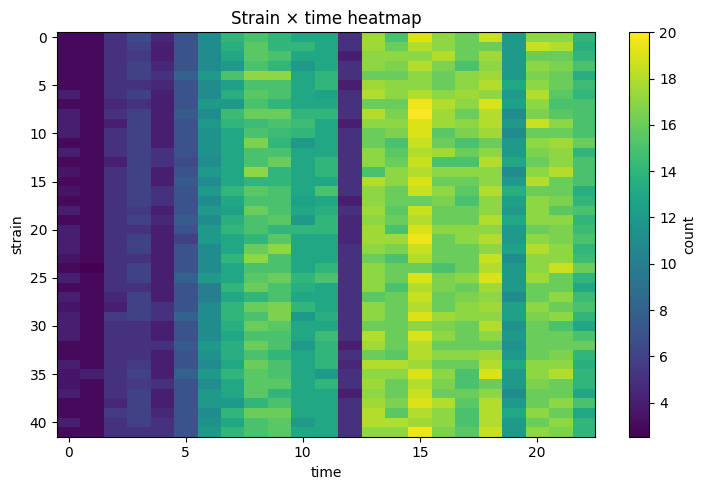

In [114]:
# ppc has shape (n_draws, n_strains, n_times)
ppc_mean = ppc.mean(axis=0)
ppc_lo, ppc_hi = np.quantile(ppc, [0.025, 0.975], axis=0)
ppc_mean = y_hat_mean
ppc_lo = lo
ppc_hi = hi
plot_heatmap(ppc_mean, fname="experimental_data/ppc_mean_heatmap_v5_numba.png")
plot_heatmap(ppc_lo,   fname="experimental_data/ppc_lo_heatmap_v5_numba.png")
plot_heatmap(ppc_hi,   fname="experimental_data/ppc_hi_heatmap_v5_numba.png")